<a href="https://colab.research.google.com/github/azfarkhoja305/GANs/blob/main/notebooks/Evaluate_TransGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization

In [100]:
# Check GPU
!nvidia-smi

Fri Apr 23 21:47:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    35W / 250W |   7635MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [101]:
import os
import sys
import pdb
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from matplotlib import animation, rc
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils

# from torchsummary import summary
from types import SimpleNamespace
import json

In [102]:
!git clone --single-branch --branch main https://github.com/azfarkhoja305/GANs.git
!git -C GANs/ pull

fatal: destination path 'GANs' already exists and is not an empty directory.
Already up to date.


In [103]:
Path.ls = lambda x: list(x.iterdir())
if Path('./GANs').exists():
    sys.path.insert(0,'./GANs')

In [104]:
from models.transformer_generator import TGenerator
from models.ViT_discriminator import Discriminator
from metrics.torch_is_fid_score import is_fid_from_generator
from utils.utils import check_gpu, display_images, set_seed, load_params
from utils.checkpoint import Checkpoint
from utils.loss import wgangp_eps_loss
from utils.datasets import ImageDataset
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
from google.colab import drive
drive.mount('/content/drive')
gdrive = Path('drive/MyDrive')
# gdrive = Path('C:\\GANs\\')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [106]:
# seed notebook
set_seed(seed=123)
device = check_gpu()
print(f'Using device: {device}')

Using device: cuda


In [107]:
# !set PYTHONPATH=%PYTHONPATH%;C:/GitHub/GANs && python ./scripts/create_fid_stats.py -d cifar_10 -t False
!PYTHONPATH=./GANs/ python GANs/scripts/create_fid_stats.py -d cifar_10 -t False

Namespace(batch_size=256, dataset='cifar_10', save='fid_stats', train='False')
Files already downloaded and verified
fid_stats/cifar_10_valid_fid_stats.npz exists. Exiting !!!


# Inference

In [108]:
gen_batch_sz = 64
dis_batch_sz = 32
latent_dims = 1024
lr, beta1, beta2 = 1e-4, 0, 0.999

In [109]:
# Add Horizontal Flip by default
tfms = [transforms.RandomHorizontalFlip()]
dataset =  ImageDataset('cifar_10', batch_sz=dis_batch_sz, tfms=tfms, 
                        num_workers=2, drop_last=True)
# display_images(dataset.train_loader)

Files already downloaded and verified


In [110]:
Gen = TGenerator(latent_dims=latent_dims).to(device)
fixed_z = torch.randn(gen_batch_sz, latent_dims, device=device)
# summary(Gen,(latent_dims,))

In [111]:
args = SimpleNamespace(**{"d_depth": 7, "df_dim": 384, "img_size": 32, "patch_size": 8})
Dis = Discriminator(args).to(device)
# summary(Dis,(3,32,32,))

In [112]:
optG = optim.AdamW(Gen.parameters(), lr=lr, betas=(beta1, beta2))
optD = optim.AdamW(Dis.parameters(), lr=lr, betas=(beta1, beta2))

In [113]:
with open(gdrive/'results.json') as fp:
  results = json.load(fp)

In [114]:
def compute_is_fid(exp, generator):
    inception_score, fid = is_fid_from_generator(generator=generator,
                                                latent_dims=latent_dims,
                                                num_imgs=10000,
                                                batch_sz=64,
                                                fid_stat_path = stat_path)
    print(f"{exp}: fid = {fid}")
    if exp not in results:
        results[exp] = {'epochs':[],'iss':[],'fids':[]}
    results[exp]['iss'].append(inception_score)
    results[exp]['fids'].append(fid)
    results[exp]['epochs'].append(epoch)

In [115]:
stat_path = Path('fid_stats/cifar_10_valid_fid_stats.npz')
experiments = ['no_aug', 'flip_lr', 'full_aug', 'co_training', "attn_init", "full_v2", "full_v2_moving_avg", "attn_init_low_lr"]

for exp in experiments:
  ckp_folder = gdrive/exp
  for filename in os.listdir(ckp_folder):
      if exp not in results:
          results[exp] = {'epochs':[],'iss':[],'fids':[]}
      epoch = int(filename[:-4].split('_')[-1])
      if epoch not in results[exp]['epochs']:
      
          Gen, gen_avg_param, Dis, optG, optD, start_epoch, step, old_logs = \
              Checkpoint.load_checkpoint(ckp_folder/filename, Gen, Dis, optG, optD)
          assert start_epoch > 0
          
          compute_is_fid(exp, Gen)
          if gen_avg_param is not None:
              load_params(Gen, gen_avg_param)
              compute_is_fid(exp + "_AVG", Gen)

          with open(gdrive/'results.json', 'w') as fp:
              json.dump(results, fp, indent=4, sort_keys=True)

# Full Analysis

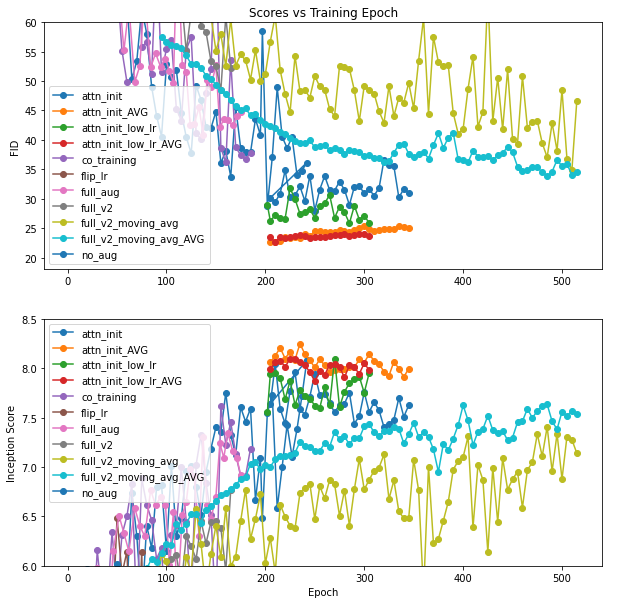

In [116]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

for idx, exp in enumerate(results.keys()):
  e = results[exp]['epochs']
  fid = results[exp]['fids']
  inception_score = results[exp]['iss']
  score = [s[0] for s in inception_score]

  axs[0].plot(e,fid,'-o',label=exp)
  axs[1].plot(e,score,'-o', label=exp)

axs[0].set_ylabel('FID')
axs[1].set_ylabel('Inception Score')
axs[0].set_ylim([18,60])
axs[1].set_ylim([6,8.5])

plt.title('Scores vs Training Epoch')
plt.xlabel("Epoch")

axs[0].legend()
axs[1].legend()
plt.show()

In [117]:
from tabulate import tabulate
table = []
for exp in results.keys():
  inception_score = [s[0] for s in results[exp]['iss']]
  table.append([exp,max(results[exp]['epochs']),results[exp]['epochs'][np.nanargmin(results[exp]['fids'])], min(results[exp]['fids']), results[exp]['epochs'][np.nanargmax(inception_score)], max(inception_score)])

print(tabulate(table, headers=["Experiment","Training Epochs","Min FID Epoch", "Min FID", "Max IS Epoch", "Max IS"]))

Experiment                Training Epochs    Min FID Epoch    Min FID    Max IS Epoch    Max IS
----------------------  -----------------  ---------------  ---------  --------------  --------
attn_init                             345              250    27.9837             242   8.08049
attn_init_AVG                         345              210    22.6475             235   8.24734
attn_init_low_lr                      305              285    25.8183             270   8.09557
attn_init_low_lr_AVG                  305              210    22.5854             225   8.095
co_training                           185              160    36.1584             155   7.6132
flip_lr                                95               20    69.9796              50   6.48188
full_aug                              175              137    40.784              162   7.3485
full_v2                               165              155    48.4732             165   6.77009
full_v2_moving_avg                    515   

# Analyze images from two models

In [118]:
import torchvision.utils as vutils

def generate_fakes(exp, epoch, Gen, Dis, optG, optD, seed=None):
    # Load model
    full_filename = gdrive/exp/f"GanModel_{epoch:03}.pth"
    Gen, gen_avg_param, Dis, optG, optD, start_epoch, step, old_logs = \
        Checkpoint.load_checkpoint(full_filename, Gen, Dis, optG, optD)
    load_params(Gen, gen_avg_param)

      # Generate images
    with torch.no_grad():
        if seed:
            torch.manual_seed(seed)
        z = torch.randn(gen_batch_sz, latent_dims, device=device)
        fake = Gen(z, epoch).detach().cpu()
    fake_ims = vutils.make_grid(fake, padding=2, normalize=True)
    return fake_ims

In [119]:
seed = 42
fake_ims1 = generate_fakes("attn_init_low_lr", 210, Gen, Dis, optG, optD, seed=seed)
fake_ims2 = generate_fakes("full_v2_moving_avg", 460, Gen, Dis, optG, optD, seed=seed)

=> Loading checkpoint: drive/MyDrive/attn_init_low_lr/GanModel_210.pth
=> Loading checkpoint: drive/MyDrive/full_v2_moving_avg/GanModel_460.pth


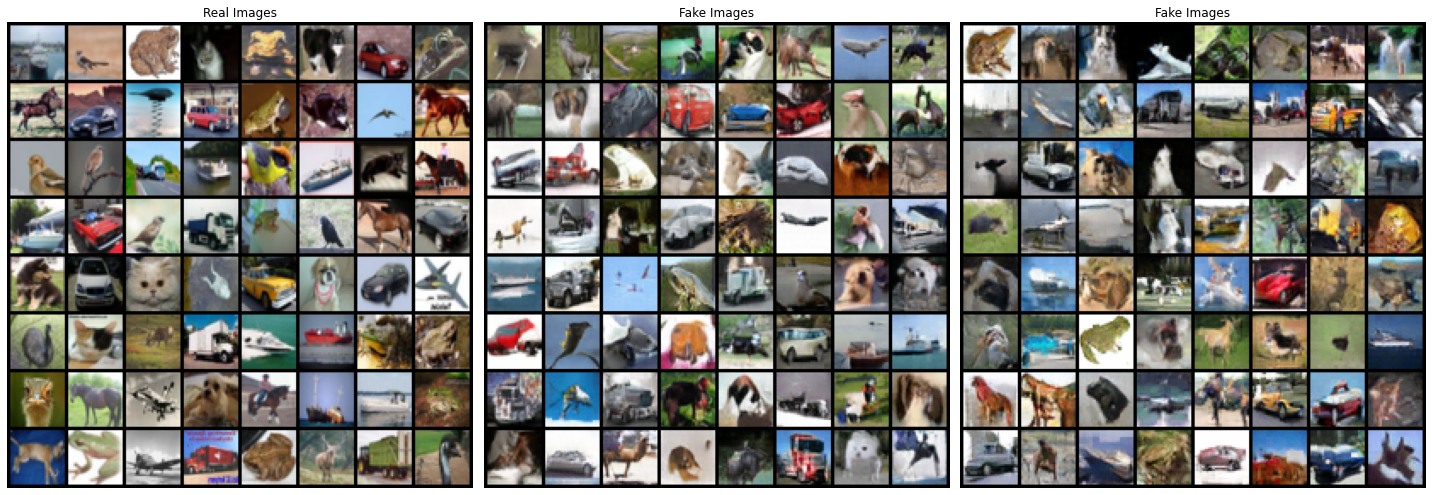

In [120]:
_, axs = plt.subplots(1,3,figsize=(20,20))
display_images(dataset.train_loader,ax = axs[0])
display_images([fake_ims1], ax = axs[1])
display_images([fake_ims2], ax = axs[2])
plt.tight_layout()

# Analyze Training Tricks

In [121]:
exps = ['no_aug', 'flip_lr', 'full_aug', 'co_training', "attn_init"]
max_epoch = 150
results['no_aug']['epochs']
results2 = {}
for exp in exps:
    results2[exp] = {'epochs':[],'iss':[],'fids':[]}
    for idx, epoch in enumerate(results[exp]['epochs']):
        if epoch <= max_epoch:
            results2[exp]['epochs'].append(epoch)
            results2[exp]['iss'].append(results[exp]['iss'][idx])
            results2[exp]['fids'].append(results[exp]['fids'][idx])

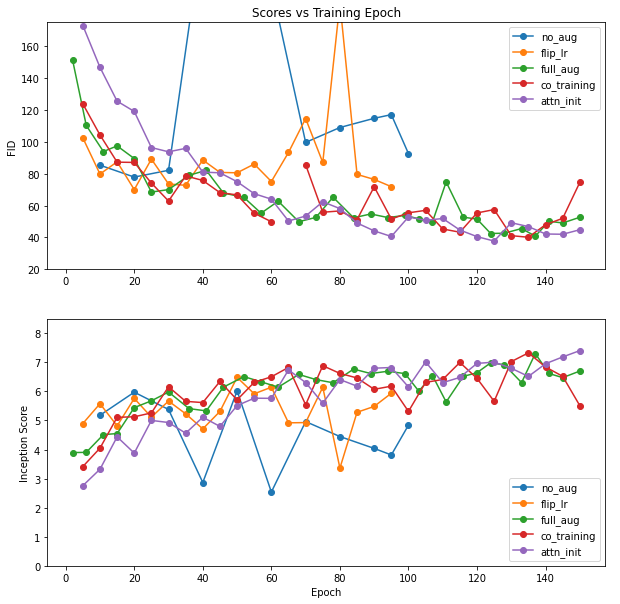

In [122]:
fig, axs = plt.subplots(2,1,figsize=(10,10))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

for idx, exp in enumerate(results2.keys()):
    e = results2[exp]['epochs']
    fid = results2[exp]['fids']
    inception_score = results2[exp]['iss']
    score = [s[0] for s in inception_score]

    axs[0].plot(e,fid,'-o',label=exp)
    axs[1].plot(e,score,'-o', label=exp)

axs[0].set_ylabel('FID')
axs[1].set_ylabel('Inception Score')
axs[0].set_ylim([20,175])
axs[1].set_ylim([0,8.5])

plt.title('Scores vs Training Epoch')
plt.xlabel("Epoch")

axs[0].legend()
axs[1].legend()
plt.show()

In [123]:
table = []
exp_titles = [
    'Vanilla TransGAN-S',
    'Above + Flip LR Augmentation',
    'Above + All Augmentations',
    'Above + Co-Training Task',
    'Above + Attention Masking',
]
for exp, title in zip(results2.keys(), exp_titles):
  inception_score = [s[0] for s in results2[exp]['iss']]
  table.append([title,max(results2[exp]['epochs']),results2[exp]['epochs'][np.nanargmin(results2[exp]['fids'])], min(results2[exp]['fids']), results2[exp]['epochs'][np.nanargmax(inception_score)], max(inception_score)])

print(tabulate(table, headers=["Experiment","Training Epochs","Min FID Epoch", "Min FID", "Max IS Epoch", "Max IS"]))

Experiment                      Training Epochs    Min FID Epoch    Min FID    Max IS Epoch    Max IS
----------------------------  -----------------  ---------------  ---------  --------------  --------
Vanilla TransGAN-S                          100               20    77.8442              50   6.01709
Above + Flip LR Augmentation                 95               20    69.9796              50   6.48188
Above + All Augmentations                   150              137    40.784              137   7.30135
Above + Co-Training Task                    150              135    40.0964             135   7.32536
Above + Attention Masking                   150              125    37.7023             150   7.40236
